In [ ]:
### どうしても、バージョンによるWarningが出力されてしまうため、'ignore'します
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

**MeCabのセッティング**

In [ ]:
!apt install aptitude

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

In [ ]:
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)


In [ ]:
!pip install mecab-python3==0.7

### MeCabを使って、形態素に慣れてみる
Google Colabratory ならば、**`!mecab`**で、お試しできる。  
`すももももものうち`

In [ ]:
!mecab

/bin/bash: mecab: command not found


## ニュースコーパスを今回も利用して、もうしこし詳細にみていきます
LDAというトピックモデルではよく扱われるものを見ていきます  
[livedoorニュースコーパスをcsvファイル形式で取得する](https://nxdataka.netlify.app/ldncsv/)  

`wget`, or `curl`
```
$ curl -O https://gist.githubusercontent.com/nxdataka/48a27b2e1c3f029e7f25e66dba4b6dde/raw/75b56c34869c6b290cdb54a0925f34baeace021a/ldn2csv.py
$ python ldn2csv.py -o Downloads/livedoornews.csv
```


LDAについての、理論的な概要はこちらを参考にしてください...！  
[LDA入門](https://www.slideshare.net/tsubosaka/tokyotextmining)  

In [ ]:
### ファイルを読み込む
### ローカルのネット環境に依存して、ちょっと時間がかかります
from google.colab import files
uploaded = files.upload()

Saving livedoornews.csv to livedoornews (1).csv


In [ ]:
import pandas as pd
import io

In [ ]:
### ニュースコーパスを、pandasモジュールのread_csvオブジェクトで読み込む
### この時、標準モジュールのioを利用して、utf-8文字コードでデコードします
data = pd.read_csv(io.StringIO(uploaded['livedoornews.csv'].decode('utf-8')))

In [ ]:
# データを見てみると
data

,url,datetime,title,body,media
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...,movie-enter
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」\n2月28日、映画『おかえり、はやぶさ』（3月...,movie-enter
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...,movie-enter
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...,movie-enter
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...,movie-enter
...,...,...,...,...,...
7362,http://news.livedoor.com/article/detail/6530260/,2012-05-05T09:55:00+0900,好きな戦士を作ってドラゴンボールの世界で天下一武道会優勝だ！「挑戦！天下一武道会」【Andr...,どんな戦士を作るかはユーザー次第！\n国民的人気を誇る鳥山明氏のマンガ／アニメである「DRA...,smax
7363,http://news.livedoor.com/article/detail/6681611/,2012-06-21T20:55:00+0900,NTTドコモ、GALAXY SIII SC-06DとF-09D ANTEPRIMAの発売日を...,GALAXY SIIIが6月28日、F-09D ANTEPRIMAが6月27日に発売！\nN...,smax
7364,http://news.livedoor.com/article/detail/6856578/,2012-08-15T11:55:00+0900,NTTドコモ、Android向け「docomo Wi-Fiかんたん接続アプリ」をバージョンア...,shimajiro@mobiler\nNTTドコモは、同社の公衆無線LANサービス「doco...,smax
7365,http://news.livedoor.com/article/detail/6678539/,2012-06-21T06:55:00+0900,NTTドコモ、PRADA Phone by LG L-02Dのデコメ絵文字popが正常に表示...,PRADA Phone by LG L-02Dにソフトウェア更新！\nNTTドコモは20日、...,smax


In [ ]:
# データのカラムを見てみる
data.columns

Index(['url', 'datetime', 'title', 'body', 'media'], dtype='object')

In [ ]:
def parse(tweet_temp):
    
    t = MeCab.Tagger() # MeCab互換の形態素解析: 形態素の例  名詞,一般,*,*,*,*,形態素,ケイタイソ,ケイタイソ
    temp1 = t.parse(tweet_temp) # 形態素が含まれている
    temp2 = temp1.split("\n") 
    
    t_list = []
    for keitaiso in temp2:
        if keitaiso not in ["EOS",""]:
            word,hinshi = keitaiso.split("\t")
            t_temp = [word]+hinshi.split(",")
            if len(t_temp) != 10:
                t_temp += ["*"]*(10 - len(t_temp))
            t_list.append(t_temp)

    return t_list

**`MeCab.Tagger()`** 形態素解析で、デフォルト設定されています

> 形態素  名詞,一般,*,*,*,*,形態素,ケイタイソ,ケイタイソ  
解析    名詞,サ変接続,*,*,*,*,解析,カイセキ,カイセキ  
EOS  

---

**`MeCab.Tagger("-Ochasen")`** ChaSen(茶筌)互換の形態素解析になります  
※茶筌: 奈良先端科学技術大学院大学(通称、NAIST)の松本研究室で誕生した形態素解析(Jumanベース)

>形態素  ケイタイソ      形態素  名詞-一般  
解析    カイセキ        解析    名詞-サ変接続  
EOS  

---

**`MeCab.Tagger("-Owakati")`**  形態素解析したものを、ただ分かち書きします

>形態素 解析

---

**`MeCab.Tagger("-Oyomi")`** 形態素解析したものを、カタカナと英単語で出力します

>ケイタイソカイセキ  

---

**`MeCab.Tagger("-Odump")`** 全情報を出力する形態素解析  

>
0 BOS BOS/EOS,*,*,*,*,*,*,*,* 0 0 0 0 0 0 2 1 0.000000 0.000000 0.000000 0  
7 形態素 名詞,一般,*,*,*,*,形態素,ケイタイソ,ケイタイソ 0 9 1285 1285 38 2 0 1 0.000000 0.000000 0.000000 5338  
13 解析 名詞,サ変接続,*,*,*,*,解析,カイセキ,カイセキ 9 15 1283 1283 36 2 0 1 0.000000 0.000000 0.000000 9241  
20 EOS BOS/EOS,*,*,*,*,*,*,*,* 15 15 0 0 0 0 3 1 0.000000 0.000000 0.000000 8505  

※ BOS は Beginning of a Sentence (文頭) の略

---

**`MeCab.Tagger("-Osimple")`** シンプルな形態素解析

>形態素  名詞-一般
解析    名詞-サ変接続
EOS

---

In [ ]:
### 任意のカラム名(MeCab.Tagger()の出力に合わせたもの)で、データフレーム作成
def parse_to_df(tweet_temp):
    return pd.DataFrame(parse(tweet_temp),
                        columns=["単語","品詞","品詞細分類1",
                                 "品詞細分類2","品詞細分類3",
                                 "活用型","活用形","原形","読み","発音"])

In [ ]:
### 与えられたテキスト群を、テキストごとに
### 名詞/一般、名詞/固有名詞、を抜き出す処理
### 原形のみを、テキストごと'doc'に格納して、１つのテキスト群から１つの'docs'を作成する
def make_lda_docs(texts):
    docs = []
    for text in texts:
        df = parse_to_df(text)
        extract_df = df[(df["品詞"]+"/"+df["品詞細分類1"]).isin(["名詞/一般","名詞/固有名詞"])]
        extract_df = extract_df[extract_df["原形"]!="*"]
        doc = []
        for genkei in extract_df["原形"]:
            doc.append(genkei)
        docs.append(doc)
    return docs

In [ ]:
import MeCab
import gensim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
### 約1分ほどで完了するスクリプト
### 文章そのものを、'texts'に格納
### LDAに与えるデータ(テキスト群から、名詞/一般、名詞/固有名詞)を、'docs'を作成
### dictionaryを作成(ユニークな単語に対して、ユニークなIDを付与した辞書型)
### 'docs'を'dictionary'ベースで、docごと固有な単語ごと出現数をベクトル化
texts = data["body"].values
docs = make_lda_docs(texts)
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
print("テキスト：")
print(texts[0][:200])
print(" ")
print("LDAで読む単語：")
print(",".join(docs[0][:50]))

テキスト：
2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。
八日目の蝉
妻子ある男と愛し合い、その子を身ごもりながら、あき
 
LDAで読む単語：
月,月,読売新聞,直木賞,作家,角田,光代,初,長編,サスペンス,蝉,檀,れい,北,きい,テレビ,ドラマ,作,月,永作,博美,井上,真央,映画,劇場,月,ブルー,レイ,蝉,妻子,男,子,女,男,妻,子供,赤ん坊,女,子,小豆島,母,娘,相手,子供,女,永作,博美,野々宮,和子,相手


In [ ]:
### 約3分前後で完了するスクリプト
### クラスタを、６つ(つまり、トピックを６つのカテゴリと仮定して設定)
### gensim.model.LdaModel からLDAトピックモデルを構築
n_cluster = 6
lda = gensim.models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_cluster, 
                minimum_probability=0.001,
                passes=20, 
                update_every=0, 
                chunksize=10000,
                random_state=1
                )

In [ ]:
### LDAトピックのコーパスを確認する
### 文書を、LDAコーパスの特徴ベクトルに変換
corpus_lda = lda[corpus]
arr_vactor = gensim.matutils.corpus2dense(
        corpus_lda,
        num_terms=n_cluster
        ).T

In [ ]:
### クラスタごとに、トピックごと、トピックを構成する単語を抽出して、
### {word}, {score}, {topic} としてデータフレームを作成
lists = []
for i in range(n_cluster):
    temp_df = pd.DataFrame(lda.show_topic(i),columns=["word","score"])
    temp_df["topic"] = i
    lists.append(temp_df)
topic_word_df = pd.concat(lists,ignore_index=True)

In [ ]:
topic_word_df

,word,score,topic
0,ネット,0.017850,0
1,情報,0.016367,0
2,記事,0.014884,0
3,日本,0.012690,0
4,韓国,0.012298,0
5,話題,0.011728,0
6,人,0.011260,0
7,掲示板,0.009287,0
8,ニュース,0.008820,0
9,声,0.008378,0


In [ ]:
topic_word_df[topic_word_df['topic'] == 0]

,word,score,topic
0,ネット,0.017850,0
1,情報,0.016367,0
2,記事,0.014884,0
3,日本,0.012690,0
4,韓国,0.012298,0
5,話題,0.011728,0
6,人,0.011260,0
7,掲示板,0.009287,0
8,ニュース,0.008820,0
9,声,0.008378,0


In [ ]:
# トピックごとに、構成される単語のランク(順位)を可視化
topic_word_df["rank"] = topic_word_df.groupby("topic")["score"].rank()
topic_word_df.pivot(index='topic', columns='rank', values='word')

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
topic,,,,,,,,,,
0,声,ニュース,掲示板,人,話題,韓国,日本,記事,情報,ネット
1,女子,日本,プロ,イベント,野球,人,人気,ゴルフ,東京,月
2,五輪,自分,女性,人,女子,サッカー,月,選手,肌,日本
3,ソフトウェア,端末,製品,モデル,ドコモ,記事,画面,月,スマート,フォン
4,シーン,話題,ドラマ,映像,日本,世界,本,作品,月,映画
5,気,独,写真,男,相手,男性,女,自分,女性,人


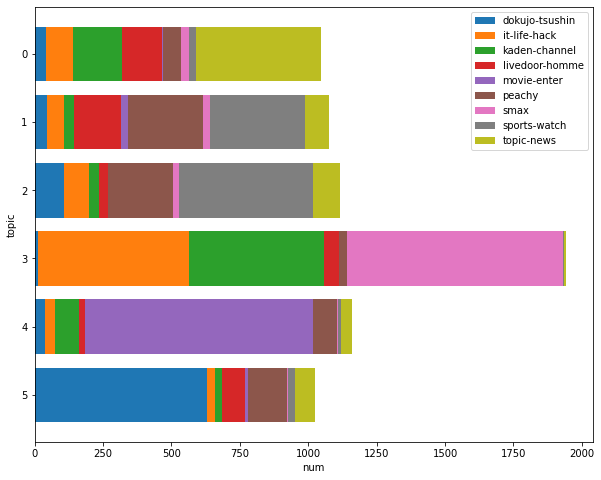

In [ ]:
data_predict = data.copy()
# topicの付与
data_predict ["pred_topic"] = np.argmax(arr_vactor,axis=1)
data_predict ["score"] = np.max(arr_vactor,axis=1)
cross = pd.crosstab(data_predict ["media"],data_predict["pred_topic"])
# トピックの文書割合の可視化
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(cross)):
    ax.barh(y=cross.columns, width = cross.iloc[i].values[::-1], left=cross.iloc[:i].sum()[::-1].values,tick_label=cross.columns[::-1])
ax.set(xlabel='num', ylabel='topic')
ax.legend(cross.index)
plt.show()

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 14.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.5 MB 58.3 MB/s 
     |████████████████████████████████| 15.7 MB 51.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e84dd70be45746bf10b47e454527eef505b590b6274e08ce9b37d2e7b43f9d8f
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take i

**[WordCloudとpyLDAvisによるLDAの可視化について](https://ie110704.net/2018/12/29/wordcloud%E3%81%A8pyldavis%E3%81%AB%E3%82%88%E3%82%8Blda%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/)**  
`pyLDAvis`は、トピックモデルをインタラクティブに可視化するためのPythonライブラリです

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim_models as gensimvis

In [ ]:
import pyLDAvis

In [ ]:
lda_vis = gensimvis.prepare(lda, corpus, dictionary)

exception calling callback for <Future at 0x7f1d2dd8a890 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py", line 616, in wait_result_broken_or_wakeup
    result_item = result_reader.recv()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from '/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    sel

BrokenProcessPool: ignored

In [ ]:
pyLDAvis.display(lda_vis)

## 映画のデータを用いた、クラスタリングとトピックモデル
**[Kaggle TMDBデータ](https://www.themoviedb.org/?language=en-US)**  
をデータセットとして、映画やテレビのトピックを分析していきます。  
`scikit-learn`の`StandardScaler`と`KMeans`を用いてクラスタリングや、  
`altair`、`gensim`、および`pyLDAvis`も利用してトピックモデルや可視化を行っていきます。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import altair as alt

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [ ]:
df = pd.read_csv('https://grantmlong.com/data/tmdb_5000_movies.csv')

In [ ]:
df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [ ]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
print(df.shape)
cluster_vars = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

(4803, 20)


In [ ]:
for col in df.columns:
  print(f'=========={col}=============')
  print(df[col])

==========budget=============
0       237000000
1       300000000
2       245000000
3       250000000
4       260000000
          ...    
4798       220000
4799         9000
4800            0
4801            0
4802            0
Name: budget, Length: 4803, dtype: int64
==========genres=============
0       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1       [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3       [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
                              ...                        
4798    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4799    [{"id": 35, "name": "Comedy"}, {"id": 10749, "...
4800    [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...
4801                                                   []
4802                  [{"id": 99, "name": "Documentary"}]
Name: genres, Length: 4803, dtype: object
==========homepage===

In [ ]:
# 指定したどれかの列に欠損値を一行でも含む場合、除去する
df = df.dropna(subset=cluster_vars+['release_date'])

In [ ]:
print(df.shape)

(4800, 20)


In [ ]:
df['release_year'] = df.release_date.str.slice(0,4).astype(int)
samp_df = df.loc[(df.release_year>=1900) &
                 (df.original_language=='ja')
                ].reset_index()

titles = {samp_df.title.loc[i] : i for i in samp_df.index.values}

print(samp_df.shape)

(16, 22)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['release_year'] = df.release_date.str.slice(0,4).astype(int)
samp_df = df.loc[(df.release_year>=1900) &
                 (df.original_language=='en')
                ].reset_index()

titles = {samp_df.title.loc[i] : i for i in samp_df.index.values}

print(samp_df.shape)

(4503, 22)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
scaler = StandardScaler()
scaler.fit(samp_df[cluster_vars].astype(float))
X = pd.DataFrame(scaler.transform(samp_df[cluster_vars].astype(float)), columns=cluster_vars)

In [ ]:
random_state = 20181126

kmeans = KMeans(n_clusters=5, 
                random_state=random_state)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
samp_df['cluster'] = (y_kmeans+1).astype(str)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

In [ ]:
x_var = 'budget'
y_var = 'revenue'

chart = alt.Chart(
      samp_df, 
      width=650,
      height=400
  ).mark_circle(
      size=80
  ).encode(
      x=x_var,
      y=y_var,
      color='cluster',
      tooltip=['title', 'revenue', 'release_date']    
  ).interactive()

In [ ]:
chart

映画データセットには、トピックモデリングで利用できる、  
映画コンテンツの簡単な概要説明も含まれています...！  
ここでは、トピックモデリングを行うために必要なbag-of-wordsスタイル分析で使用するために、  
生のテキスト(Row Text)をトークンに変換します。


In [ ]:
for i in np.random.choice(df.index.values, 3):
    print()
    print(df.overview.loc[i], '\n')


B Movie Legend Bruce Campbell is mistaken for his character Ash from the Evil Dead trilogy and forced to fight a real monster in a small town in Oregon. 


A team of highly skilled Navy SEALS find themselves embarking on the battle of their lives when they come face-to-face with the undead. After a deadly outbreak occurs in New Orleans, the SEALS must fight for their lives, and the city, against an army of zombies. 


Futuristic action about a man who meets a clone of himself and stumbles into a grand conspiracy about clones taking over the world. 



In [ ]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=8,
                             max_features=1000,
                             stop_words='english'
                            )

X_text = pd.DataFrame((vectorizer.fit_transform(samp_df.overview)>0).toarray())
all_words = vectorizer.get_feature_names()
d = {i : all_words[i] for i in range(len(all_words))}

tokens = [[d[j] for j in X_text.columns[X_text.loc[i]].tolist()] for i in range(X_text.shape[0])]

print(np.random.choice(tokens, 2))

[list(['civil', 'group', 'held', 'holds', 'hometown', 'life', 'looking', 'love', 'man', 'outside', 'reporter', 'romance', 'run', 'second', 'secret', 'soldiers', 'stories', 'strange', 'ultimate', 'uncle', 'war', 'woman', 'younger'])
 list(['brothers', 'dying', 'father', 'order', 'pair', 'perfect', 'try'])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [ ]:
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [ ]:
ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=30, random_state=random_state)
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

ストリーミング出力は最後の 5000 行に切り捨てられました。
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogth

(0, '0.019*"help" + 0.015*"world" + 0.013*"young" + 0.012*"evil" + 0.011*"time" + 0.010*"family"')
(1, '0.023*"school" + 0.023*"high" + 0.018*"group" + 0.016*"deadly" + 0.014*"student" + 0.014*"team"')
(2, '0.034*"new" + 0.028*"york" + 0.026*"city" + 0.015*"drug" + 0.014*"girlfriend" + 0.013*"los"')
(3, '0.049*"story" + 0.041*"film" + 0.025*"true" + 0.021*"american" + 0.020*"world" + 0.017*"documentary"')
(4, '0.020*"agent" + 0.019*"secret" + 0.014*"finds" + 0.013*"young" + 0.012*"mysterious" + 0.012*"mission"')
(5, '0.022*"old" + 0.019*"father" + 0.016*"man" + 0.015*"life" + 0.014*"year" + 0.014*"friend"')
(6, '0.025*"life" + 0.021*"old" + 0.020*"friends" + 0.019*"family" + 0.019*"new" + 0.018*"lives"')
(7, '0.022*"life" + 0.016*"young" + 0.014*"years" + 0.013*"time" + 0.011*"finds" + 0.011*"man"')
(8, '0.019*"movie" + 0.018*"young" + 0.017*"world" + 0.016*"life" + 0.014*"boy" + 0.014*"film"')
(9, '0.018*"group" + 0.017*"earth" + 0.016*"war" + 0.015*"team" + 0.014*"stop" + 0.012*"army

In [ ]:
import pyLDAvis

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
pyLDAvis.display(lda_display)

### アイデア のみになります...人名から国籍を判別する深層学習モデル
**佐藤一宏 → Kazuhiro Sato → kazuhirosato → 11, 1, 26, ... , 15**  
0 は空白として使います(ゼロパディング, ゼロ埋め)  
すべての人名を、a~zのアルファベット表記にします。

In [ ]:
import re, os, time, difflib, pandas as pd, numpy as np
from itertools import product

In [ ]:
alpha_dict = {'a':1,
              'b':2,
              'c':3,
              'd':4,
              'e':5,
              'f':6,
              'g':7,
              'h':8,
              'i':9,
              'j':10,
              'k':11,
              'l':12,
              'm':13,
              'n':14,
              'o':15,
              'p':16,
              'q':17,
              'r':18,
              's':19,
              't':20,
              'u':21,
              'v':22,
              'w':23,
              'x':24,
              'y':25,
              'z':26}

latin_dict = {'à':'a',
              'â':'a',
              'ä':'a',
              'á':'a',
              'å':'aa',
              'é':'e',
              'è':'e',
              'ê':'e',
              'ë':'e',
              'ñ':'gn',
              'î':'i',
              'ï':'i',
              'í':'l',
              'ì':'i',
              'ô':'o',
              'ö':'o',
              'ó':'o',
              'ò':'o',
              'ø':'o',
              'ç':'s',
              'ş':'s',
              'ß':'ss',
              'ù':'u',
              'û':'u',
              'ü':'u',
              'ú':'u',
              'ÿ':'y',
              'æ':'ae',
              'œ':'oe'}

In [ ]:
def make_MLdata(personname_dict, data_length):
    
    empty_tuple = ()
    y_train = []
    
    for foreign_name, personname_data in personname_dict.items():
        
        for item in personname_data[0:data_length]:
            item_str = str(item)
            item_str = item_str.replace('[', '')
            item_str = item_str.replace(']', '')
            item_str = item_str.replace("'", '')
            item_str = item_str.replace('"', '')
            item_str = item_str.replace(' ', '')
            item_str = item_str.replace('-', '')
            item_list = list(item_str)
    
            for key, value in latin_dict.items():
                item_list = [s.replace(key, value) for s in item_list]
        
            for key, value in alpha_dict.items():
                item_list = [s.replace(key, str(value)) for s in item_list]
        
            item_list = [int(s) for s in item_list]
    
            item_tuple = item_list,
            empty_tuple = empty_tuple + item_tuple
    
    x_train = np.array(empty_tuple)
    
    del empty_tuple
    
    return x_train

In [ ]:
DIR_PATH = '/Users/Toki/Downloads/Foreign_name_analysis/dict_fullname_by_country/'

In [ ]:
def load_dictionary(dir_path):
    
    dutch_fullname = np.loadtxt(dir_path+'dutch_fullname.csv',
                                 delimiter=',', dtype=str)
    english_fullname = np.loadtxt(dir_path+'english_fullname.csv',
                                  delimiter=',', dtype=str)
    finnish_fullname = np.loadtxt(dir_path+'finnish_fullname.csv',
                                  delimiter=',', dtype=str)
    franch_fullname = np.loadtxt(dir_path+'franch_fullname.csv',
                                 delimiter=',', dtype=str)
    german_fullname = np.loadtxt(dir_path+'german_fullname.csv',
                                 delimiter=',', dtype=str)
    itarian_fullname = np.loadtxt(dir_path+'itarian_fullname.csv',
                                 delimiter=',', dtype=str)
    spanish_fullname = np.loadtxt(dir_path+'spanish_fullname.csv',
                                 delimiter=',', dtype=str)
    swedish_fullname = np.loadtxt(dir_path+'swedish_fullname.csv',
                                 delimiter=',', dtype=str)
    japanese_fullname = np.loadtxt(dir_path+'japanese_fullname.csv',
                               delimiter=',', dtype=str)
    chinese_fullname = np.loadtxt(dir_path+'chinese_fullname.csv',
                               delimiter=',', dtype=str)
    korean_fullname = np.loadtxt(dir_path+'korean_fullname.csv',
                               delimiter=',', dtype=str)
    
    dictData = {'dutch_fullname':dutch_fullname,
                'english_fullname':english_fullname,
                'finnish_fullname':finnish_fullname,
                'franch_fullname':franch_fullname,
                'german_fullname':german_fullname,
                'itarian_fullname': itarian_fullname,
                'spanish_fullname':spanish_fullname,
                'swedish_fullname':swedish_fullname,
                'japanese_fullname':japanese_fullname,
                'chinese_fullname':chinese_fullname,
                'korean_fullname':korean_fullname}
    return dictData

In [ ]:
data_tuple = make_MLdata(load_dictionary(DIR_PATH), 10000)

In [ ]:
from keras.preprocessing import sequence

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:29: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from tensorflow.python.lib.core import _pywrap_bfloat16
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:511: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:553: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecatio

In [ ]:
### シーケンスの最大が３０文字と仮定(データはきちんと確認する)
data_x = sequence.pad_sequences(data_tuple, maxlen=30)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, MaxPool1D, Bidirectional, LSTM
from keras.layers import InputLayer, Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [ ]:
init_array = np.zeros((110000, 11), dtype=np.int)

In [ ]:
length = 10000
for i in range(length):
    init_array[i,0] = int(1)
for i in range(length):
    init_array[i+length,1] = int(1)
for i in range(length):
    init_array[i+length*2,2] = int(1)
for i in range(length):
    init_array[i+length*3,3] = int(1)
for i in range(length):
    init_array[i+length*4,4] = int(1)
for i in range(length):
    init_array[i+length*5,5] = int(1)
for i in range(length):
    init_array[i+length*6,6] = int(1)
for i in range(length):
    init_array[i+length*7,7] = int(1)
for i in range(length):
    init_array[i+length*8,8] = int(1)
for i in range(length):
    init_array[i+length*9,9] = int(1)
for i in range(length):
    init_array[i+length*10,10] = int(1)

In [ ]:
data_y = init_array

In [ ]:
x = data_x
y = data_y
p = np.random.permutation(len(x))
x = x[p]
y = y[p]

In [ ]:
train_x = x[:90000,:]
train_y = y[:90000,]
test_x = x[90000:,:]
test_y = y[90000:,]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
#from keras.engine import InputSpec, Layer

In [ ]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

In [ ]:
inp = Input(shape = (train_x.shape[1],))
x = Embedding(10000, 26)(inp)
x = SpatialDropout1D(0.2)(x)

#auto-encoder

x = Bidirectional(GRU(128, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

x = Dense(11, activation = "sigmoid")(x)
model = Model(inputs = inp, outputs = x)
model.compile(loss = "binary_crossentropy",
              optimizer = Adam(lr = 1e-3, decay = 0),
              metrics = ["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_x, train_y,
                    batch_size = 128,
                    epochs = 50,
                    validation_data = (test_x, test_y), 
                    verbose = 1)
                    #callbacks = [ra_val, check_point, early_stop])